## Building a PyTorch model for multiclass classification problem

In [ ]:
# Installing Python packages
!pip install torchmetrics

In [ ]:
## Importing dependencies

# Dependencies for data creation and manipulation
import torch
from torch import nn
from torchmetrics import Accuracy
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [ ]:
# Setting up device agnostic code
device = "cuda" if torch.cuda.is_available else "cpu"
print(f"Available device: {device}")

Available device: cuda


In [ ]:
# Setting hyperparameters for the data creation
NUM_SAMPLES = 1000
RANDOM_SEED = 42
NUM_CLASSES = 5
CLUSTER_STD = 1.5

# Setting hyperparameters for train-test split
TEST_SIZE = 0.2

# Setting hyperparameters for optimizer and model training
LEARNING_RATE = 0.1
EPOCHS = 100

Features type:  <class 'numpy.ndarray'>
Features shape:  (1000, 2)
Number of features:  2
Targets type:  <class 'numpy.ndarray'>
Targets shape:  (1000,)


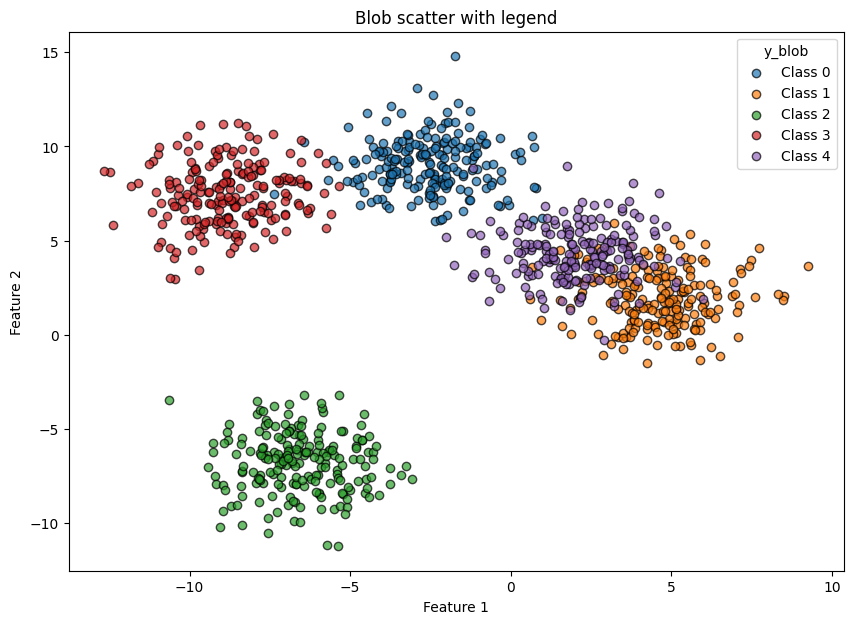

Shape of training data: torch.Size([800, 2])
Shape of testing data: torch.Size([200, 2])


In [ ]:
# Loading and preparing data
X_blob, y_blob = make_blobs(n_samples = NUM_SAMPLES,
                            random_state = RANDOM_SEED,
                            centers = NUM_CLASSES,
                            cluster_std = CLUSTER_STD)
print("Features type: ", type(X_blob))
print("Features shape: ", X_blob.shape)
print("Number of features: ", X_blob.shape[1])
print("Targets type: ", type(y_blob))
print("Targets shape: ", y_blob.shape)

# Converting data from numpy array to tensor
# For y, check with loss function requirements
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# Visualizing data (plotting features)
plt.figure(figsize = (10, 7))
classes = np.unique(y_blob)

for cls in classes:
    mask = (y_blob == cls)
    plt.scatter(
        X_blob[mask, 0],
        X_blob[mask, 1],
        label=f'Class {cls}',
        edgecolor = "k",
        alpha = 0.7
    )

plt.legend(title='y_blob')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Blob scatter with legend')
plt.show()

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X_blob,
                                                    y_blob,
                                                    random_state = RANDOM_SEED,
                                                    test_size = TEST_SIZE)

print(f"Shape of training data: {X_train.shape}")
print(f"Shape of testing data: {X_test.shape}")

In [ ]:
# Building PyTorch model
class CirclesV0(nn.Module):

  def __init__(self, NUM_FEATURES, HIDDEN_UNITS, NUM_CLASSES):
    super().__init__()

    self.two_linear_layers = nn.Sequential(
        nn.Linear(in_features = NUM_FEATURES, out_features = HIDDEN_UNITS),
        nn.Linear(in_features = HIDDEN_UNITS, out_features = NUM_CLASSES)
    )

  def forward(self, x):
    return self.two_linear_layers(x)

In [ ]:
# Setting hyperparameters for neural network
NUM_FEATURES = X_blob.shape[1]
HIDDEN_UNITS = 5

# Instantiating the model and pushing it to the device
model_0 = CirclesV0(NUM_FEATURES = NUM_FEATURES,
                    HIDDEN_UNITS = HIDDEN_UNITS,
                    NUM_CLASSES = NUM_CLASSES).to(device)

# Pushing datasets and model to device
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)
model_0 = model_0.to(device)

model_0

CirclesV0(
  (two_linear_layers): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=5, bias=True)
  )
)

In [ ]:
# Setting up loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
accuracy_fn = Accuracy(task = "multiclass", num_classes= NUM_CLASSES).to(device)
optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = LEARNING_RATE)

In [ ]:
## Making preliminary predictions with the model

# Setting the model to evaluation mode
model_0.eval()

with torch.inference_mode():
  y_logits = model_0(X_test)

# Converting logits to prediction probability
# dim = 1 because each suite of prediction probabilities are a vector
y_pred_prob = torch.softmax(y_logits, dim=1)

# Converting prediction probability into predictions
y_pred = torch.argmax(y_pred_prob, dim=1).type(torch.float)
print(f"Predictions by untrained model for the first 5 observations: {y_pred[:5]}")
print(f"True output labels for first 5 observations: {y_test[:5]}")

Predictions by untrained model for the first 5 observations: tensor([2., 2., 2., 4., 2.], device='cuda:0')
True output labels for first 5 observations: tensor([0, 1, 1, 2, 0], device='cuda:0')


In [ ]:
# Creating a training loop and testing loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = EPOCHS

for epoch in range(epochs):

  ### Training
  model_0.train()

  y_logits = model_0(X_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_pred, y_train)

  # Resetting all gradients for each epoch
  optimizer.zero_grad()

  # Performing backpropagation
  loss.backward()

  # Letting optimizer update parameters for each epoch
  optimizer.step()

  ### Testing
  model_0.eval()

  with torch.inference_mode():
    test_logits = model_0(X_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(test_pred, y_test)

    # Print out what's happening
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} |  Loss: {loss} | Acc: {acc}% | Test loss: {test_loss} | Test acc: {test_acc}%")


Epoch: 0 |  Loss: 0.1600259244441986 | Acc: 0.9424999952316284% | Test loss: 0.16172975301742554 | Test acc: 0.925000011920929%
Epoch: 100 |  Loss: 0.1591731607913971 | Acc: 0.9437500238418579% | Test loss: 0.16109050810337067 | Test acc: 0.925000011920929%
Epoch: 200 |  Loss: 0.15842166543006897 | Acc: 0.9449999928474426% | Test loss: 0.16052238643169403 | Test acc: 0.925000011920929%
Epoch: 300 |  Loss: 0.15775427222251892 | Acc: 0.9462500214576721% | Test loss: 0.16001519560813904 | Test acc: 0.925000011920929%
Epoch: 400 |  Loss: 0.1571575105190277 | Acc: 0.9449999928474426% | Test loss: 0.15956152975559235 | Test acc: 0.925000011920929%
Epoch: 500 |  Loss: 0.15662086009979248 | Acc: 0.9449999928474426% | Test loss: 0.1591552495956421 | Test acc: 0.925000011920929%
Epoch: 600 |  Loss: 0.1561357080936432 | Acc: 0.9449999928474426% | Test loss: 0.1587914675474167 | Test acc: 0.9200000166893005%
Epoch: 700 |  Loss: 0.15569491684436798 | Acc: 0.9449999928474426% | Test loss: 0.15846569

In [ ]:
# Making predictions with the model
model_0.eval()

model_0.to(device)

with torch.inference_mode():
  y_logits = model_0(X_test)

y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred = torch.argmax(y_pred_probs, dim=1).type(torch.int)
print(f"Predictions by trained model for first 5 observations: {y_pred[:5]}")
print(f"True output labels for first 5 observations: {y_test[:5]}")

Predictions by trained model for first 5 observations: tensor([0, 1, 4, 2, 0], device='cuda:0', dtype=torch.int32)
True output labels for first 5 observations: tensor([0, 1, 1, 2, 0], device='cuda:0')


helper_functions.py already exists, skipping download


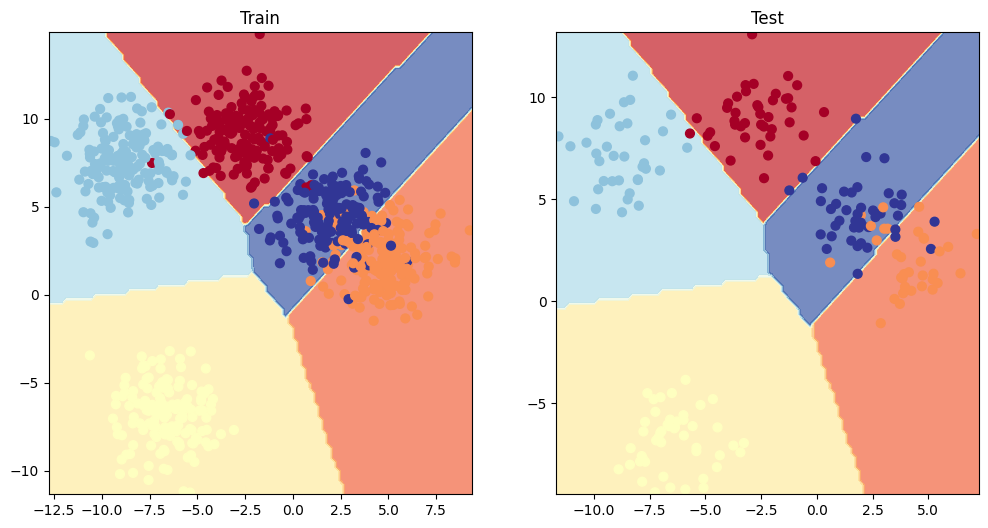

In [ ]:
# Evaluating the model
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")

else:
  print("Download helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")

  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

# Plot decision boundary of the model
from helper_functions import plot_predictions, plot_decision_boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)